![image](https://user-images.githubusercontent.com/8471958/101298709-27848700-37e4-11eb-9163-e47e79bd08c4.png)

- https://github.com/MorvanZhou/pytorch-A3C

In [14]:
import gym
import math
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable
from torch.distributions import Categorical

In [27]:
class A3C_Net(nn.Module):
    def __init__(self, hidden_n, hidden_dim, activation_function='relu'):
        super(A3C_Net, self).__init__()
        
        self.env = gym.make('CartPole-v0')
        self.state_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space.n
        
        self.hidden_n = hidden_n
        self.hidden_dim = hidden_dim
        
        self.activation_function = activation_function
        if activation_function == 'relu':
            self.activation = F.relu
        elif activation_function == 'tanh':
            self.activation = torch.tanh
            
        self.input_layer = nn.Linear(self.state_space, hidden_dim[0])

        if hidden_n > 1:
            hidden_layers = []
            for i in range(hidden_n-1):
                hidden_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            self.hidden_layers = nn.Sequential(*hidden_layers)

        self.actor_layer = nn.Linear(hidden_dim[-1], self.action_space)
        self.critic_layer = nn.Linear(hidden_dim[-1], 1)
        
        self.SavedAction = namedtuple('SavedAction', ['log_prob', 'exp_q'])
        self.saved_actions, self.rewards = [], []
        
    def forward(self, x):
        x = self.activation(self.input_layer(x))
        
        if self.hidden_n > 1:
            for i in range(self.hidden_n-1):
                x = self.activation(self.hidden_layers[i](x))
        
        action_prob = F.softmax(self.actor_layer(x), dim=-1)
        exp_q = self.critic_layer(x)
        
        return action_prob, exp_q

    def choose_action(self, state):
        self.eval()
        action_prob, exp_q = self.forward(state)
        m = Categorical(action_prob)
        action = m.sample()
        self.saved_actions.append(self.SavedAction(m.log_prob(action), exp_q))
        return action.numpy()[0]
    
    def loss_func(self, optimizer, global_net, done, next_state, gamma=.99):
        R = 0 if done else self.forward(self.v_wrap(next_state[None, :]))[-1].data.numpy()[0, 0]
        
        # N-step Bootstrapping
        discounted_rewards = []
        for r in self.rewards[::-1]:
            R = r + gamma * R
            discounted_rewards.insert(0, R)
            
        discounted_rewards = self.v_wrap(np.array(discounted_rewards)[:, None])

        self.train()
        log_prob = torch.stack([sa.log_prob for sa in self.saved_actions])
        log_prob.view(log_prob.shape[0], -1)
        exp_q = torch.stack([sa.exp_q[0] for sa in self.saved_actions])
        exp_q.view(exp_q.shape[0], -1)
        
        advantage = discounted_rewards - exp_q
        policy_losses = F.smooth_l1_loss(exp_q, discounted_rewards)
        value_losses = -(log_prob * advantage.detach().squeeze())

        loss = policy_losses.sum() + value_losses.sum()
            
        # calculate local gradients and push local parameters to global
        optimizer.zero_grad()
        loss.backward()
        for lp, gp in zip(self.parameters(), global_net.parameters()):
            gp._grad = lp.grad
        optimizer.step()
        
        del self.rewards[:]
        del self.saved_actions[:]
        
        return global_net.state_dict()
    
    def v_wrap(self, np_array, dtype=np.float32):
        if np_array.dtype != dtype:
            np_array = np_array.astype(dtype)
        return torch.from_numpy(np_array)    

In [33]:
class A3C_Worker(mp.Process):
    def __init__(self, global_net, optimizer, g_ep, g_ep_r, res_queue, worker_num, update_iter=5, MAX_EP=3000):
        super(A3C_Worker, self).__init__()
        
        self.MAP_EP = MAX_EP
        self.update_iter = update_iter
        self.worker_name = 'Worker-%d' % worker_num
        
        self.global_net = global_net
        self.optimizer = optimizer
        
        self.g_ep, self.g_ep_r, self.res_queue = g_ep, g_ep_r, res_queue
        
        self.local_net = A3C_Net(self.global_net.hidden_n, self.global_net.hidden_dim, self.global_net.activation_function)
        self.env = gym.make('CartPole-v0')

    def run(self):
        total_step = 1
        while self.g_ep.value < self.MAP_EP:
            state = self.env.reset()
            ep_r = 0.
            while True:
                action = self.local_net.choose_action(self.local_net.v_wrap(state[None, :]))
                next_state, reward, done, _ = self.env.step(action)
                if done: reward = -1
                ep_r += reward
                self.local_net.rewards.append(reward)

                if total_step % self.update_iter == 0 or done:  # update global and assign to local net
                    # sync
                    self.update_global_net(done, next_state)

                    if done:  # done and print information
                        self.record(ep_r)
                        break
                state = next_state
                total_step += 1
        self.res_queue.put(None)

    def update_global_net(self, done, next_state):
        # pull global parameters
        self.local_net.load_state_dict(self.local_net.loss_func(self.optimizer, self.global_net, done, next_state))

    def record(self, ep_r):
        with self.g_ep.get_lock():
            self.g_ep.value += 1
        with self.g_ep_r.get_lock():
            if self.g_ep_r.value == 0.:
                self.g_ep_r.value = ep_r
            else:
                self.g_ep_r.value = self.g_ep_r.value * 0.99 + ep_r * 0.01
        self.res_queue.put(self.g_ep_r.value)
        if self.g_ep.value % 100 == 0:
            print('[%s] EP %d : %.4f' % (self.worker_name, self.g_ep.value, self.g_ep_r.value))

In [39]:
a3c_model = A3C_Net(3, [256, 128, 64], 'tanh')
a3c_model.share_memory()
optimizer = torch.optim.Adam(a3c_model.parameters(), lr=1e-4, betas=(.92, .999))
global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

In [40]:
# Parallel Training
workers = [A3C_Worker(a3c_model, optimizer, global_ep, global_ep_r, res_queue, i) for i in range(mp.cpu_count())]

In [41]:
[w.start() for w in workers]
res = []
while True:
    r = res_queue.get()
    if r is not None:
        res.append(r)
    else:
        break
[w.join() for w in workers]

[Worker-2] EP 100 : 25.9414
[Worker-15] EP 200 : 17.9925
[Worker-6] EP 300 : 13.9053
[Worker-0] EP 400 : 18.6735
[Worker-3] EP 500 : 18.9714
[Worker-12] EP 600 : 20.8845
[Worker-10] EP 700 : 70.9856
[Worker-8] EP 800 : 96.2875
[Worker-13] EP 900 : 140.0413
[Worker-14] EP 1000 : 168.4846
[Worker-11] EP 1100 : 136.6451
[Worker-3] EP 1200 : 172.6208
[Worker-6] EP 1300 : 161.3065
[Worker-4] EP 1400 : 132.8819
[Worker-15] EP 1500 : 162.1434
[Worker-15] EP 1600 : 182.4030
[Worker-15] EP 1700 : 186.2743
[Worker-12] EP 1800 : 156.1120
[Worker-6] EP 1900 : 129.2857
[Worker-4] EP 2000 : 142.3036
[Worker-9] EP 2100 : 147.6030
[Worker-12] EP 2200 : 169.0405
[Worker-14] EP 2300 : 171.0870
[Worker-9] EP 2400 : 167.0912
[Worker-10] EP 2500 : 186.6864
[Worker-10] EP 2600 : 193.1297
[Worker-3] EP 2700 : 195.2348
[Worker-1] EP 2800 : 188.5511
[Worker-2] EP 2900 : 194.5414
[Worker-6] EP 3000 : 196.7340


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

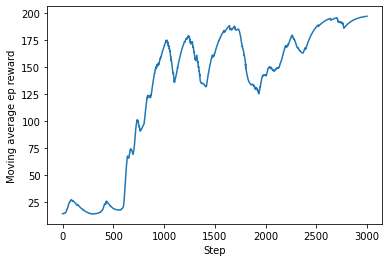

In [42]:
import matplotlib.pyplot as plt
plt.plot(res)
plt.ylabel('Moving average ep reward')
plt.xlabel('Step')
plt.show()